In [ ]:
!pip install datasets
!pip install transformers
!pip install nltk
!pip install matplotlib
!pip install torch
!pip install ipywidgets
!pip install huggingface_hub
!pip install accelerate

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from huggingface_hub import notebook_login
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
import numpy as np
import nltk
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import json
from torch.cuda import amp
from huggingface_hub import notebook_login

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/techlab/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Hyperparameters
max_token = 32
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 10
batch_size = 120
validation_batch_size = 10
weight_decay = 1e-3
drop_out_rate = 0.5
lr = 1e-3
gamma = 0.8
num_layer = 12
gradient_accumulation_step = 1

# Load gpt2 and use its tokenizer and word embedding

In [3]:
# Download gpt2 and its tokenizer
model_name = "gpt2-medium"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Store all word embedding
word_embeddings = model.transformer.wte

# Delete gpt2 becase we are no longer using it.|
del model

# Store how many embedding and embedding dimension of our gpt2
num_embeddings, embedding_dim = word_embeddings.weight.size()

# Create a padding embedding and initialize the padding embedding with zeros
padding_embedding = torch.nn.Embedding(1, embedding_dim)
padding_embedding.weight.data.zero_()
num_embeddings += 1

# Concatenate the new padding embedding with the existing word embeddings
word_embeddings_tensor = torch.cat([word_embeddings.weight, padding_embedding.weight], 0)
word_embeddings_tensor = word_embeddings_tensor.to(device)

# Preprocessing

In [ ]:
# Run this code if you want to do data preprocessing
tokenized_data = []
attention_data = []

# Download dataset
dataset = load_dataset("wikipedia", "20220301.en", trust_remote_code=True)
training_dataset = dataset["train"]

# Tokenize all training data and filter those longer than token limit
for i in tqdm(range(len(training_dataset))):
    text = training_dataset[i]["text"]
    sentences = nltk.sent_tokenize(text)
    sentences = [sentence+"<|endoftext|>" for sentence in sentences]

    # Tokenize input
    tokenized_sentence = tokenizer(sentences, padding='max_length', max_length=max_token)
    input_ids = tokenized_sentence["input_ids"]
    attention_mask = tokenized_sentence["attention_mask"]

    # Filter those longer than max_token
    for j in range(len(input_ids)):
        if len(input_ids[j]) <= max_token:
            tokenized_data.append(input_ids[j])
            attention_data.append(attention_mask[j])
            
    if i == 100000:
        break

# Write into json
with open('tokenized_data.json', 'w') as file:
    # Write the JSON data
    json.dump(tokenized_data, file)

with open('attention_data.json', 'w') as file:
    # Write the JSON data
    json.dump(attention_data, file)

In [4]:
# Load from json (If you had already preprocessed)
with open('tokenized_data.json', 'r') as file:
    # Load the data from the file
    tokenized_data = json.load(file)

with open('attention_data.json', 'r') as file:
    # Load the data from the file
    attention_data = json.load(file)

In [5]:
total_data_num = len(tokenized_data)
training_data_num = int(total_data_num * 0.98)

training_data = torch.tensor(tokenized_data[:training_data_num])
training_attention = torch.tensor(attention_data[:training_data_num])
validation_data = torch.tensor(tokenized_data[training_data_num:])
validation_attention = torch.tensor(attention_data[training_data_num:])

# Create a TensorDataset
training_data = TensorDataset(training_data, training_attention)
validation_data = TensorDataset(validation_data, validation_attention)

# Use DataLoader for batching, etc.
training_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=validation_batch_size, shuffle=True)

# Free up memory
del tokenized_data
del attention_data

# Create positional embedding

In [6]:
# Positional encoding
max_token_pos = max_token - 1
pos_matrix = torch.empty(max_token_pos, embedding_dim)
for i in range(max_token_pos):
    for j in range(0, embedding_dim, 2):
        pos_matrix[i, j] = np.sin(i/(10000**(j/embedding_dim)))
        if(j+1<embedding_dim):
            pos_matrix[i, j+1] = np.cos(i/(10000**(j/embedding_dim)))
pos_matrix = pos_matrix.to(device)

# Instantiate LLM

In [7]:
class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, tensor: torch.Tensor) -> torch.Tensor:
        return tensor * torch.sigmoid(tensor)

class SwiGLU(nn.Module):
    def __init__(self, embedding_dim: int):
        super().__init__()
        self.W = nn.Linear(embedding_dim, embedding_dim)
        self.V = nn.Linear(embedding_dim, embedding_dim)
        self.swish = Swish()

    def forward(self, tensor: torch.Tensor) -> torch.Tensor:
        W = self.W(tensor)
        V = self.V(tensor)
        return self.swish(W) * V

# This is root mean square norm implementation by author
# I do not take any credit for this
class RMSNorm(nn.Module):
    def __init__(self, d, p=-1., eps=1e-8, bias=False):
        """
            Root Mean Square Layer Normalization
        :param d: model size
        :param p: partial RMSNorm, valid value [0, 1], default -1.0 (disabled)
        :param eps:  epsilon value, default 1e-8
        :param bias: whether use bias term for RMSNorm, disabled by
            default because RMSNorm doesn't enforce re-centering invariance.
        """
        super().__init__()

        self.eps = eps
        self.d = d
        self.p = p
        self.bias = bias

        self.scale = nn.Parameter(torch.ones(d))
        self.register_parameter("scale", self.scale)

        if self.bias:
            self.offset = nn.Parameter(torch.zeros(d))
            self.register_parameter("offset", self.offset)

    def forward(self, x):
        if self.p < 0. or self.p > 1.:
            norm_x = x.norm(2, dim=-1, keepdim=True)
            d_x = self.d
        else:
            partial_size = int(self.d * self.p)
            partial_x, _ = torch.split(x, [partial_size, self.d - partial_size], dim=-1)

            norm_x = partial_x.norm(2, dim=-1, keepdim=True)
            d_x = partial_size

        rms_x = norm_x * d_x ** (-1. / 2)
        x_normed = x / (rms_x + self.eps)

        if self.bias:
            return self.scale * x_normed + self.offset

        return self.scale * x_normed

class MyLlamaLayer(nn.Module):
    def __init__(self, embedding_dim: int, num_heads: int, expand_factor: int = 4):
        super().__init__()
        # Transformer layer
        self.rms_norm1 = RMSNorm(embedding_dim)
        self.multihead_attention = nn.MultiheadAttention(embedding_dim, num_heads=num_heads)
        self.rms_norm2 = RMSNorm(embedding_dim)
        
        # Feed forward network
        self.fc1 = nn.Linear(embedding_dim, embedding_dim*expand_factor, bias=False)
        self.fc2 = nn.Linear(embedding_dim, embedding_dim*expand_factor, bias=False)
        self.fc3 = nn.Linear(embedding_dim*expand_factor, embedding_dim, bias=False)

    def forward(self, tensor: torch.Tensor, causal_mask: torch.Tensor) -> torch.Tensor:
        # Reshape to follow [seq_length, batch_size, embedding_size]
        tensor = tensor.transpose(0, 1)

        # Go through the transformer layer
        tensor_skip = tensor
        tensor = self.rms_norm1(tensor)
        tensor_skip = tensor_skip + self.multihead_attention(tensor, tensor, tensor, attn_mask=causal_mask, is_causal=True)[0]
        tensor = self.rms_norm2(tensor_skip)
        tensor_skip = self.fc3(F.silu(self.fc1(tensor)) * self.fc2(tensor)) + tensor_skip
        
        return tensor_skip.transpose(0, 1)

class MyLlama(nn.Module):
    def __init__(self, embedding_dim: int, num_layer: int, num_heads: int = None):
        super().__init__()
        if num_heads == None: # Default is to use a head for every 64 values
            self.num_heads = int(embedding_dim/64)

        # Transformer
        self.transformer = nn.ModuleList()
        for i in range(num_layer):
            self.transformer.append(MyLlamaLayer(embedding_dim, self.num_heads))

        self.norm = RMSNorm(embedding_dim)

        # Classifier
        self.classifier = nn.Linear(embedding_dim, num_embeddings)

    def forward(self, tensor: torch.Tensor):
        # Create causal mask
        causal_mask = torch.triu(torch.ones(tensor.shape[1], tensor.shape[1]) * float('-inf'), diagonal=1).to(device)
        
        # Transformer
        for layer in self.transformer:
            tensor = layer(tensor, causal_mask)

        tensor = self.norm(tensor)

        # Classifier
        return self.classifier(tensor)

In [8]:
llama = MyLlama(embedding_dim, num_layer).to(device)
print("This model has", sum(p.numel() for p in llama.parameters()), "parameters.")
scaler = amp.GradScaler()

This model has 252915794 parameters.


# Training

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(llama.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)

In [10]:
loss_train = []
loss_valid = []

100%|█████████████████████████████████████| 11039/11039 [03:02<00:00, 60.61it/s]

Training loss:  2.7924231395390526
Validation loss:  2.9402050623395692


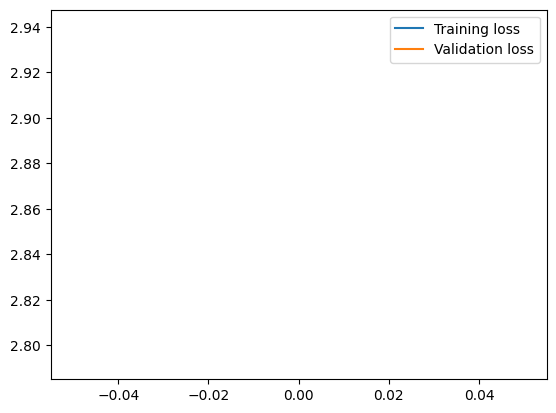

100%|█████████████████████████████████████| 11039/11039 [03:02<00:00, 60.51it/s]

Training loss:  2.5611219334799125
Validation loss:  2.837306708505117


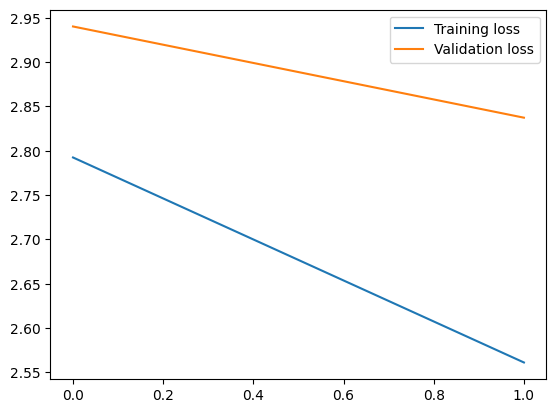

100%|█████████████████████████████████████| 11039/11039 [03:04<00:00, 59.92it/s]

Training loss:  2.4626362760884635
Validation loss:  2.7609493199957593


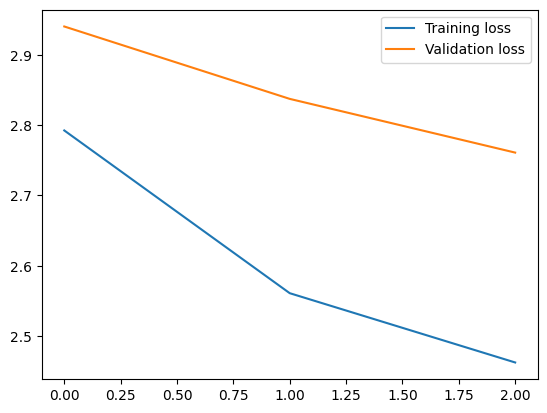

100%|█████████████████████████████████████| 11039/11039 [03:04<00:00, 59.77it/s]

Training loss:  2.395656881939314
Validation loss:  2.702482037110566


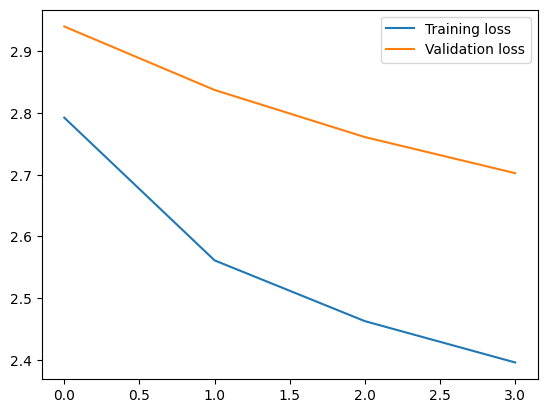

100%|█████████████████████████████████████| 11039/11039 [03:04<00:00, 59.79it/s]


Training loss:  2.331449483274784
Validation loss:  2.665020816902156


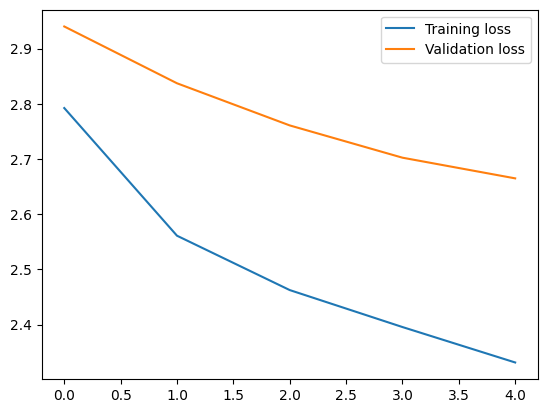

100%|█████████████████████████████████████| 11039/11039 [03:04<00:00, 59.76it/s]


Training loss:  2.279143824262924
Validation loss:  2.6313428302121795


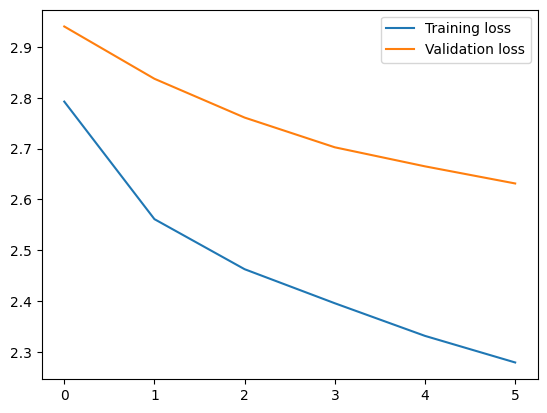

100%|█████████████████████████████████████| 11039/11039 [03:04<00:00, 59.81it/s]


Training loss:  2.2395558481092235
Validation loss:  2.6106662029092194


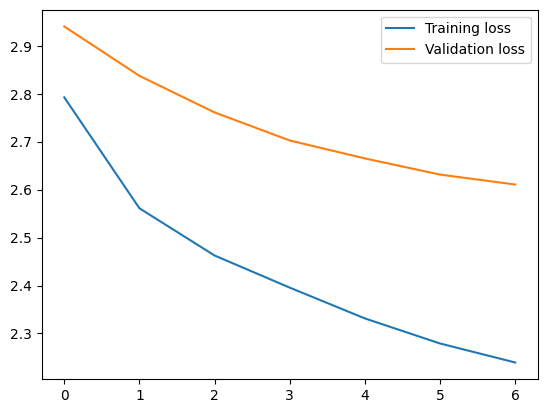

100%|█████████████████████████████████████| 11039/11039 [03:04<00:00, 59.68it/s]


Training loss:  2.21045841203849
Validation loss:  2.597423760255336


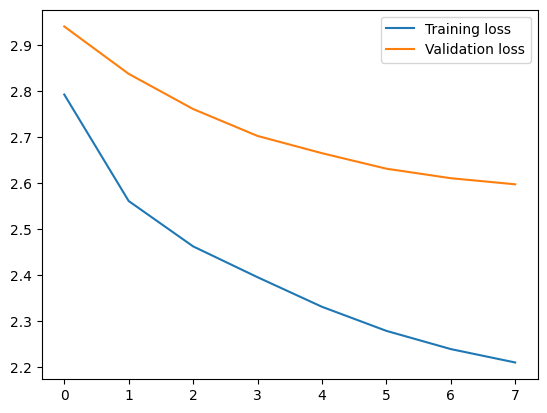

100%|█████████████████████████████████████| 11039/11039 [03:04<00:00, 59.90it/s]


Training loss:  2.191109402204473
Validation loss:  2.5890492730862484


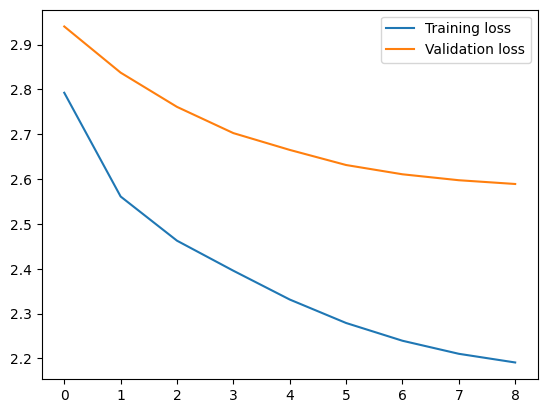

100%|█████████████████████████████████████| 11039/11039 [03:04<00:00, 59.75it/s]


Training loss:  2.1803994853129356
Validation loss:  2.587582114900689


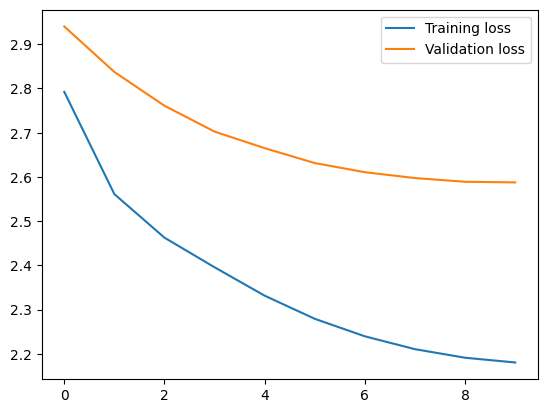

In [11]:
for epoch in range(epochs):
    loss_train_epoch = []
    loss_val_epoch = []
    for batch_idx, data in enumerate(tqdm(training_loader)):
        # Teacher forcing
        input_data = data[0][:, :-1].to(device)
        target_data = data[0][:, 1:].to(device)

        # Convert to embedding.
        input_embeddings = word_embeddings_tensor[input_data]
        input_embeddings = input_embeddings + pos_matrix

        # Forward pass
        with amp.autocast():
            prediction = llama(input_embeddings)

            # Change shape for loss calculation
            prediction = prediction.view(-1, num_embeddings)
            target_data = target_data.reshape(-1)
            loss = criterion(prediction, target_data) # Calculate loss
            scaler.scale(loss/gradient_accumulation_step).backward()

        # Backward pass
        if (batch_idx + 1) % gradient_accumulation_step == 0 or (batch_idx + 1) == len(training_loader):
            torch.nn.utils.clip_grad_norm_(llama.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            # Clear out grad
            optimizer.zero_grad()

        # Record loss
        loss_train_epoch.append(loss.item())

    loss_train.append(np.mean(loss_train_epoch))

    with torch.no_grad():
        for data in tqdm(validation_loader):
            # Teacher forcing
            input_data = data[0][:, :-1].to(device)
            target_data = data[0][:, 1:].to(device)
    
            # Convert to embedding.
            input_embeddings = word_embeddings_tensor[input_data]
            input_embeddings = input_embeddings + pos_matrix
    
            # Forward pass
            with amp.autocast():
                prediction = llama(input_embeddings)
    
                # Change shape for loss calculation
                prediction = prediction.view(-1, num_embeddings)
                target_data = target_data.reshape(-1)
                loss = criterion(prediction, target_data) # Calculate loss
    
            # Record loss
            loss_val_epoch.append(loss.item())
    
        loss_valid.append(np.mean(loss_val_epoch))

    scheduler.step()

    plt.plot(loss_train, label="Training loss")
    plt.plot(loss_valid, label="Validation loss")
    print("Training loss: ", loss_train[-1])
    print("Validation loss: ", loss_valid[-1])
    plt.legend()
    plt.show()

# Inference

In [25]:
temperature = 0.1

In [30]:
sentence = "Apple is a fruit produced by"
tokenized_sentence = tokenizer(sentence)["input_ids"]

with torch.no_grad():
    while(tokenized_sentence[-1] != tokenizer.eos_token_id and len(tokenized_sentence) < max_token): # Keep iterating until reaches end of sentence or max token limit
        # Preparing input
        tokenized_sentence_tensor = torch.tensor(tokenized_sentence)
        sentence_embedding = word_embeddings_tensor[tokenized_sentence_tensor] + pos_matrix[:len(tokenized_sentence_tensor)].unsqueeze(0)
        sentence_embedding = sentence_embedding.to(device)

        # Make prediction
        with amp.autocast():
            prediction = llama(sentence_embedding)
        prediction = prediction[0][-1] # We only care about last token
        prediction = prediction / temperature
        prediction = F.softmax(prediction, dim=-1)
        output_token = torch.multinomial(prediction, 1)

        # Append to conversation history
        tokenized_sentence.append(output_token.item())

tokens = tokenizer.decode(tokenized_sentence)
print(tokens)

Apple is a fruit produced by the company of the same name.<|endoftext|>


# Save the model

In [ ]:
torch.save(llama, '2dot8.pth')